In [2]:
# ## Preliminaries

In [3]:
# Includes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from groupBMC.groupBMC import GroupBMC
from scipy.special import logsumexp

np.set_printoptions(suppress=True, precision=3)

In [4]:
# Load data

from load_data import load_data_for_experiment, UNIQUE_CHOICE_COLUMNS_NO_UNCUED, load_data_for_experiments

#experiment_version = "V1.2_pilot"
#data = load_data_for_experiment(experiment_version, choice_columns=UNIQUE_CHOICE_COLUMNS_NO_UNCUED)

experiment_version = "V0.6_pilot"
data = load_data_for_experiment(experiment_version)

#experiment_versions = ["V0.3_pilot", "V1.0_pilot", "V1.1_pilot"]
#experiment_version = "V0.3_1.0_1.1_pilot"
#data = load_data_for_experiments(experiment_versions)

df_counts = data['df_counts']

In [5]:
# Multinomial mixture EM algorithm

def compute_cluster_loglikelihood(pi_j, theta_j, counts):
    """Compute log-likelihood for a single cluster.
    
    The probability is computed as:
    P(data | cluster j) = π_j * ∏_k (θ_j[k])^(counts[k])
    
    In log space:
    log P(data | cluster j) = log(π_j) + Σ_k counts[k] * log(θ_j[k])
    
    Args:
        pi_j: Cluster probability (scalar)
        theta_j: Cluster parameters (1D array)
        counts: Count data (2D array: subjects x categories)
    
    Returns:
        1D array of log-likelihoods for each subject
    """
    return np.log(pi_j) + (counts * np.log(theta_j + 1e-12)).sum(axis=1)

def multinomial_mixture_EM(counts, n_clusters=2, max_iter=200, tol=1e-6, seed=0):
    rng = np.random.default_rng(seed)
    S, K = counts.shape
    N = counts.sum(axis=1, keepdims=True)
    # initialize cluster probabilities randomly
    theta = rng.dirichlet(np.ones(K), size=n_clusters)
    pi = np.ones(n_clusters) / n_clusters

    for it in range(max_iter):
        # --- E-step ---
        loglik = np.zeros((S, n_clusters))
        for j in range(n_clusters):
            loglik[:, j] = compute_cluster_loglikelihood(pi[j], theta[j], counts)
        r = np.exp(loglik - logsumexp(loglik, axis=1, keepdims=True))

        # --- M-step ---
        pi_new = r.mean(axis=0)
        theta_new = np.zeros_like(theta)
        for j in range(n_clusters):
            w = r[:, j:j+1]
            theta_new[j] = (w.T @ counts).ravel()
        theta_new /= theta_new.sum(axis=1, keepdims=True)

        # convergence check
        diff = np.abs(theta_new - theta).max()
        theta, pi = theta_new, pi_new
        if diff < tol:
            break

    # compute total log-likelihood
    loglik_final = np.zeros((S, n_clusters))
    for j in range(n_clusters):
        loglik_final[:, j] = compute_cluster_loglikelihood(pi[j], theta[j], counts)
    ll = logsumexp(loglik_final, axis=1).sum()

    return pi, theta, r, ll

In [6]:
# Run the EM algorithm

pi, theta, r, ll = multinomial_mixture_EM(df_counts.to_numpy(), n_clusters=3)

print('Choice categories: ', data['choice_columns'])
print("Cluster probabilities:", pi)
print("Cluster means:", theta)
print("Responsibilities:", r)

Choice categories:  ['gpi zero', 'policy reuse max rew. test', 'policy reuse min rew. test', 'policy reuse uncued', 'mb/gpi', 'null trajectories']
Cluster probabilities: [0.575 0.241 0.184]
Cluster means: [[0.119 0.195 0.16  0.068 0.192 0.266]
 [0.042 0.434 0.434 0.    0.058 0.032]
 [0.342 0.189 0.188 0.127 0.046 0.107]]
Responsibilities: [[0.995 0.    0.005]
 [1.    0.    0.   ]
 [0.999 0.    0.001]
 [0.669 0.    0.331]
 [0.99  0.    0.01 ]
 [0.    1.    0.   ]
 [0.999 0.    0.001]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.003 0.    0.997]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.999 0.    0.   ]
 [0.998 0.    0.002]
 [0.004 0.    0.996]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [0.006 0.    0.994]
 [0.    1.    0.   ]
 [0.    0.    1.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [1.    0.    0.   ]
 [0.    1.    0.   ]
 [0.999 0.    0.001]
 [1.    0.    0.   ]]


In [7]:
# Fit models for a range of cluster counts

counts = df_counts.to_numpy()
S, K = counts.shape
cluster_range = range(1, 10)

results = {}
for C in cluster_range:
    print(f"Fitting model with {C} clusters...")
    pi_c, theta_c, r_c, ll_c = multinomial_mixture_EM(counts, n_clusters=C)
    n_params = C * (K - 1) + (C - 1)
    results[C] = {'pi': pi_c, 'theta': theta_c, 'r': r_c, 'll': ll_c, 'n_params': n_params}

Fitting model with 1 clusters...
Fitting model with 2 clusters...
Fitting model with 3 clusters...
Fitting model with 4 clusters...
Fitting model with 5 clusters...
Fitting model with 6 clusters...
Fitting model with 7 clusters...
Fitting model with 8 clusters...
Fitting model with 9 clusters...


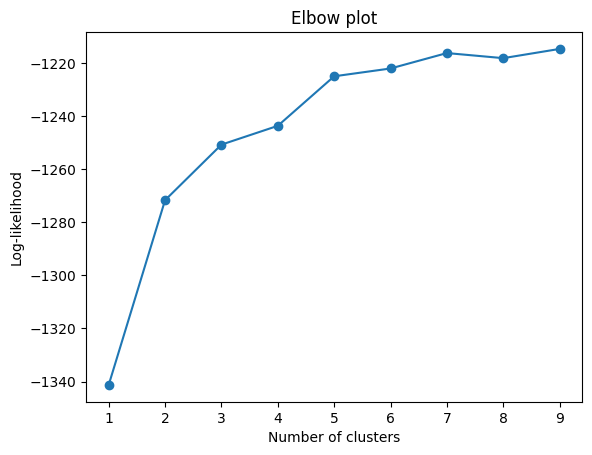

In [8]:
# Elbow plot (log-likelihood vs. number of clusters)

lls = [results[C]['ll'] for C in cluster_range]

plt.figure()
plt.plot(list(cluster_range), lls, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Log-likelihood')
plt.title('Elbow plot')
plt.savefig(f'results/{experiment_version}/em_clusters_elbow.png', dpi=150, bbox_inches='tight')
plt.show()

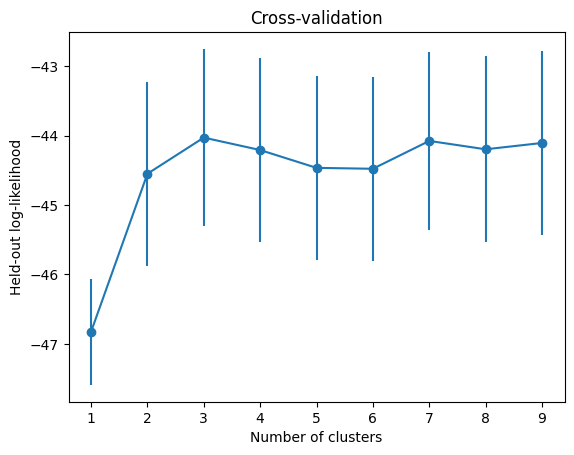

In [9]:
# Held-out log-likelihood using cross-validation

from sklearn.model_selection import KFold

n_folds = S
cv_ll = {C: [] for C in cluster_range}

kf = KFold(n_splits=n_folds, shuffle=True, random_state=0)
for train_idx, test_idx in kf.split(counts):
    for C in cluster_range:
        pi_c, theta_c, _, _ = multinomial_mixture_EM(counts[train_idx], n_clusters=C)
        loglik_test = np.zeros((len(test_idx), C))
        for j in range(C):
            loglik_test[:, j] = compute_cluster_loglikelihood(pi_c[j], theta_c[j], counts[test_idx])
        cv_ll[C].append(logsumexp(loglik_test, axis=1).sum())

mean_cv_ll = [np.mean(cv_ll[C]) for C in cluster_range]
sem_cv_ll = [np.std(cv_ll[C]) / np.sqrt(len(cv_ll[C])) for C in cluster_range]

plt.figure()
plt.errorbar(list(cluster_range), mean_cv_ll, yerr=sem_cv_ll, fmt='o-')
plt.xlabel('Number of clusters')
plt.ylabel('Held-out log-likelihood')
plt.title('Cross-validation')
plt.savefig(f'results/{experiment_version}/em_clusters_cv.png', dpi=150, bbox_inches='tight')
plt.show()

Kneedle elbow (CV log-likelihood): 3


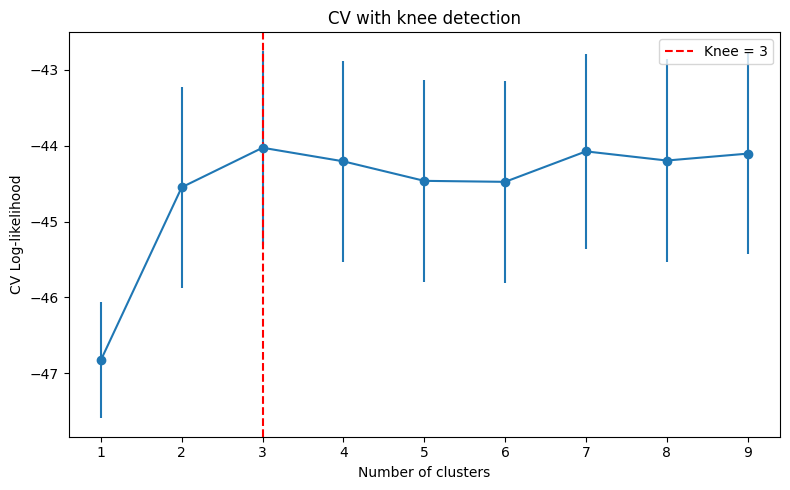

In [10]:
# Method 1: Elbow detection using kneedle algorithm

from kneed import KneeLocator

kneedle_cv = KneeLocator(list(cluster_range), mean_cv_ll, curve='concave', direction='increasing')
print(f"Kneedle elbow (CV log-likelihood): {kneedle_cv.knee}")

# Plot with knee point marked
plt.figure(figsize=(8, 5))
plt.errorbar(list(cluster_range), mean_cv_ll, yerr=sem_cv_ll, fmt='o-')
if kneedle_cv.knee:
    plt.axvline(x=kneedle_cv.knee, color='r', linestyle='--', label=f'Knee = {kneedle_cv.knee}')
plt.xlabel('Number of clusters')
plt.ylabel('CV Log-likelihood')
plt.title('CV with knee detection')
plt.legend()
plt.tight_layout()
plt.savefig(f'results/{experiment_version}/em_clusters_knee.png', dpi=150, bbox_inches='tight')
plt.show()


Marginal gain analysis:
  Max marginal gain: 69.61 (from 1 to 2 clusters)
  First k where gain < 10% of max: 6 clusters


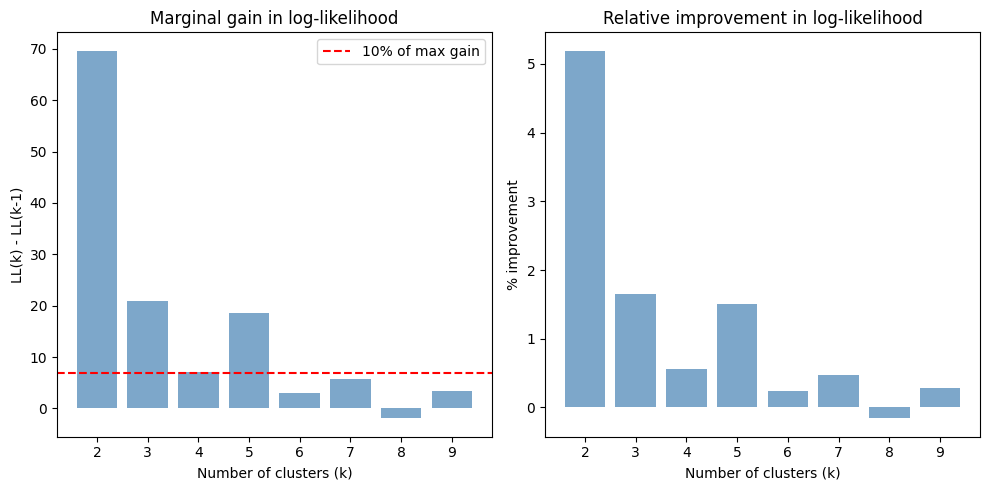

In [11]:
# Method 3: Rate of improvement / marginal gain analysis

lls_arr = np.array(lls)
marginal_gain = np.diff(lls_arr)  # improvement from k to k+1
relative_gain = marginal_gain / np.abs(lls_arr[:-1])  # relative improvement

# Find where marginal gain drops below threshold (e.g., 1% of max gain)
threshold = 0.1 * marginal_gain.max()
first_below_threshold = np.argmax(marginal_gain < threshold) + 1  # +1 because diff reduces length by 1, +1 for 1-indexing

print(f"\nMarginal gain analysis:")
print(f"  Max marginal gain: {marginal_gain.max():.2f} (from {list(cluster_range)[np.argmax(marginal_gain)]} to {list(cluster_range)[np.argmax(marginal_gain)+1]} clusters)")
print(f"  First k where gain < 10% of max: {list(cluster_range)[first_below_threshold]} clusters")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(list(cluster_range)[1:], marginal_gain, alpha=0.7, color='steelblue')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'10% of max gain')
plt.xlabel('Number of clusters (k)')
plt.ylabel('LL(k) - LL(k-1)')
plt.title('Marginal gain in log-likelihood')
plt.legend()

plt.subplot(1, 2, 2)
plt.bar(list(cluster_range)[1:], relative_gain * 100, alpha=0.7, color='steelblue')
plt.xlabel('Number of clusters (k)')
plt.ylabel('% improvement')
plt.title('Relative improvement in log-likelihood')
plt.tight_layout()
plt.savefig(f'results/{experiment_version}/em_clusters_marginal_gain.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Method 4: Paired t-tests between adjacent models (using per-subject log-likelihoods)

from scipy import stats

# approximate per-subject log model evidence using BIC_i = ll_i - (k/2) * log(N_i)
n_models = len(cluster_range)
logliks = np.zeros((S, n_models))
bics = np.zeros((S, n_models))  # subjects x models

for idx, C in enumerate(cluster_range):
    res = results[C]
    pi_c, theta_c = res['pi'], res['theta']
    n_params = res['n_params']
    loglik_s = np.zeros((S, C))
    for j in range(C):
        loglik_s[:, j] = compute_cluster_loglikelihood(pi_c[j], theta_c[j], counts)
    logliks[:, idx] = logsumexp(loglik_s, axis=1)
    N_per_subject = counts.sum(axis=1)
    bics[:, idx] = n_params * np.log(N_per_subject) - 2 * logliks[:, idx] 

print("\nPaired t-tests (k vs k+1 clusters):")
print("-" * 60)
p_values = []
for i, C in enumerate(list(cluster_range)[:-1]):
    C_next = C + 1
    # Get per-subject log-likelihoods for both models
    ll_k = logliks[:, i]
    ll_k1 = logliks[:, i + 1]
    
    # Paired t-test (one-sided: is k+1 significantly better than k?)
    t_stat, p_val = stats.ttest_rel(ll_k1, ll_k, alternative='greater')
    p_values.append(p_val)
    
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
    print(f"  {C} vs {C_next} clusters: t = {t_stat:6.2f}, p = {p_val:.4f} {sig}")

# Find first non-significant improvement
first_nonsig = next((i for i, p in enumerate(p_values) if p > 0.05), len(p_values))
print("-" * 60)
print(f"First non-significant improvement (p > 0.05): {list(cluster_range)[first_nonsig]} -> {list(cluster_range)[first_nonsig + 1]} clusters")
print(f"Suggested k based on paired t-tests: {list(cluster_range)[first_nonsig]}")


Paired t-tests (k vs k+1 clusters):
------------------------------------------------------------
  1 vs 2 clusters: t =   3.08, p = 0.0023 **
  2 vs 3 clusters: t =   2.25, p = 0.0162 *
  3 vs 4 clusters: t =   0.94, p = 0.1786 
  4 vs 5 clusters: t =   1.25, p = 0.1108 
  5 vs 6 clusters: t =   0.78, p = 0.2202 
  6 vs 7 clusters: t =   1.63, p = 0.0566 
  7 vs 8 clusters: t =  -0.21, p = 0.5837 
  8 vs 9 clusters: t =   0.54, p = 0.2982 
------------------------------------------------------------
First non-significant improvement (p > 0.05): 3 -> 4 clusters
Suggested k based on paired t-tests: 3
